Imports


In [13]:
# Install haversine if required
#!pip install haversine

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import geopy.distance
import haversine as hs
from haversine import Unit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from tkinter import filedialog

Load data


In [14]:
# Load dataset
file_path = filedialog.askopenfilename(title="Select the CSV file")

df = pd.read_csv(file_path)


Drop column 1 and 2

In [15]:
# Remove unnecessary columns
df.drop(['key','Unnamed: 0'], axis=1, inplace=True)
df.dropna(axis=0,inplace=True)

In [16]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())



Missing values in the dataset:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [17]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

print('\r\n')

# Display the columns of the dataset
print("Fields of the dataset:")
print(df.columns)

First few rows of the dataset:
   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1          7.7  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2         12.9  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3          5.3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4         16.0  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5  


Fields of the dataset:
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',

Extract hours from date time

In [18]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [19]:
# Convert 'pickup_datetime' to a datetime data type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the date, time, and other components
df['Hour'] = df['pickup_datetime'].dt.hour


In [20]:
df.drop('pickup_datetime', axis=1, inplace=True)




Remove latitude and longitude values not in range

In [21]:
#Drop the rows where the latitude and longitude are not in range
condition = df[
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
].index
df.drop(condition, inplace=True)

Calculate Distance

In [22]:
#Calculate the distance between pickup and dropoffm
longitude, latitude = [], []

longitude.append(df["pickup_longitude"].tolist())
longitude.append(df["dropoff_longitude"].tolist())
latitude.append(df["pickup_latitude"].tolist())
latitude.append(df["dropoff_latitude"].tolist())

#Find the distance in miles
distance = [hs.haversine((latitude[1][i], longitude[1][i]), (latitude[0][i], longitude[0][i]), unit=Unit.KILOMETERS)
              for i in range(len(longitude[0]))]

#Append the new distance column to the dataset
df['distance'] = distance

In [23]:

df.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] , inplace=True , axis= 1)
df.head()

,fare_amount,passenger_count,Hour,distance
0,7.5,1,19,1.683325
1,7.7,1,20,2.457593
2,12.9,1,21,5.036384
3,5.3,3,8,1.661686
4,16.0,5,17,4.475456


Remove Outliers

In [25]:
#Drop the rows where the fare amount is <=0 and distance is <=0

df.drop(df[df['fare_amount']<=0].index,inplace=True)
df.drop(df[df['distance']<=0].index,inplace=True)
df.drop(df[df['distance']>60].index,inplace=True)

#drop outlier distance and fair amount
df.drop(df[df['distance']>100].index,inplace=True)
df.drop(df[df['fare_amount']>100].index,inplace=True)

#drop unrealistic fair amounts and distance travelled
df.drop(df[(df['fare_amount']>=100) & (df['distance']<=1)].index,inplace=True)
df.drop(df[(df['fare_amount']<=100) & (df['distance']>=100)].index,inplace=True)


Distance vs fare amount graph

Text(0, 0.5, 'fare_amount')

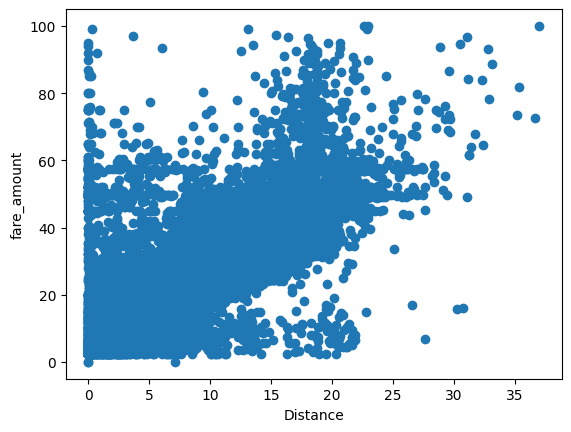

In [26]:
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [27]:
x = df.drop(['fare_amount'],axis = 1)
y = df['fare_amount'].values.reshape(-1, 1)

In [28]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

Standardize values

In [29]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [30]:
# Model Evaluation
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=42)

Linear Regression


In [31]:
# Create linear model and train
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LR_y_predict = LR.predict(x_test)

Linear Regression Accuracy


In [32]:
# Calculate regression metrics
LRmse = mean_squared_error(y_test, LR_y_predict)
mae = mean_absolute_error(y_test, LR_y_predict)
r2 = r2_score(y_test, LR_y_predict)
rmse = np.sqrt(LRmse)
print(f"Mean Squared Error (MSE): {LRmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R2): {r2:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")


Linear Regression Mean Squared Error: 0.2078
Linear Regression Root Mean Squared Error: 0.4559
Linear Regression Mean Absolute Error: 0.2466
Linear Regression R-squared: 0.7891


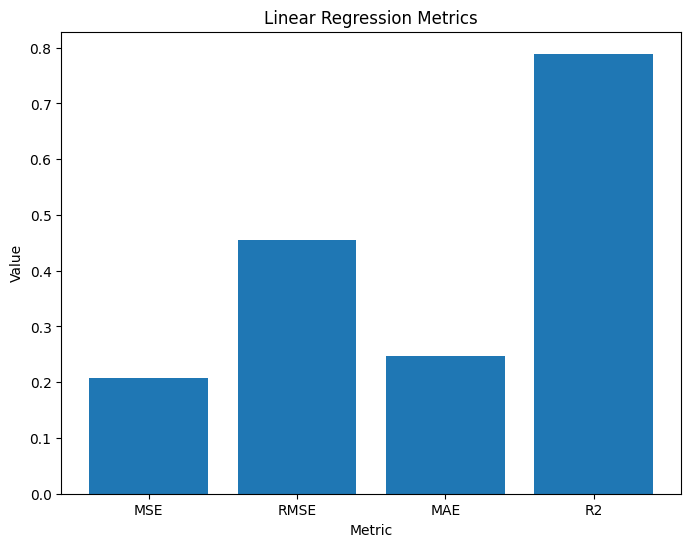

In [33]:
import matplotlib.pyplot as plt

metrics = ['MSE', 'RMSE', 'MAE','R2']
values = [LRmse, rmse, mae,r2]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Linear Regression Metrics')
plt.show()

Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(x_train, y_train.ravel())
# Make predictions on the test set
RF_y_pred = rf_regressor.predict(x_test)

In [35]:
# Calculate regression metrics
RFmse = mean_squared_error(y_test, RF_y_pred)
mae = mean_absolute_error(y_test, RF_y_pred)
r2 = r2_score(y_test, RF_y_pred)
rmse = np.sqrt(RFmse)

print(f"Random Forest - Mean Squared Error (MSE): {RFmse:.6f}")
print(f"Random Forest - Mean Absolute Error (MAE): {mae:.6f}")
print(f"Random Forest - R-squared (R2): {r2:.6f}")
print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse:.6f}")

Random Forest Mean Squared Error: 0.2303
Random Forest Root Mean Squared Error: 0.4799
Random Forest Mean Absolute Error: 0.2702
Random Forest R-squared: 0.7663


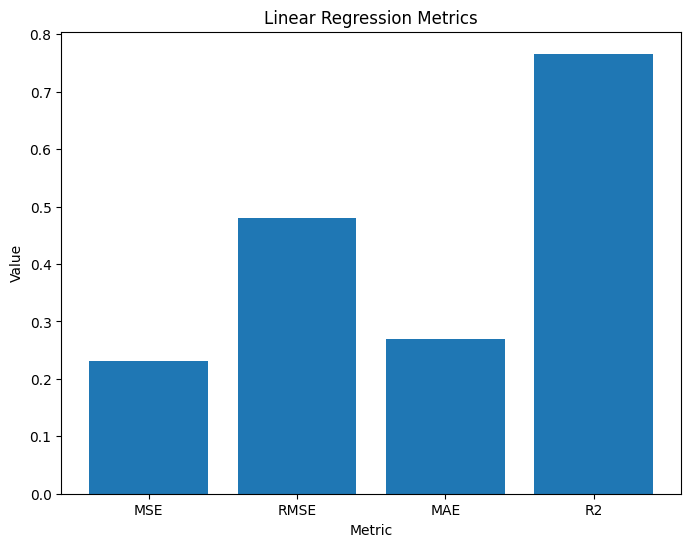

In [36]:
import matplotlib.pyplot as plt

metrics = ['MSE', 'RMSE', 'MAE','R2']
values = [RFmse, rmse, mae,r2]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Linear Regression Metrics')
plt.show()

Gradiant Boosting Regression

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(x_train, y_train.ravel())

# Make predictions on the test set
GB_y_pred = gb_regressor.predict(x_test)

In [38]:
# Calculate regression metrics
GBmse = mean_squared_error(y_test, GB_y_pred)
mae = mean_absolute_error(y_test, GB_y_pred)
r2 = r2_score(y_test, GB_y_pred)
rmse = np.sqrt(GBmse)

print(f"Gradient Boosting - Mean Squared Error (MSE): {GBmse:.6f}")
print(f"Gradient Boosting - Mean Absolute Error (MAE): {mae:.6f}")
print(f"Gradient Boosting - R-squared (R2): {r2:.6f}")
print(f"Gradient Boosting - Root Mean Squared Error (RMSE): {rmse:.6f}")


Gradient Boosting Mean Squared Error: 0.1885
Gradient Boosting Root Mean Squared Error: 0.4342
Gradient Boosting Mean Absolute Error: 0.2373
Gradient Boosting R-squared: 0.8087


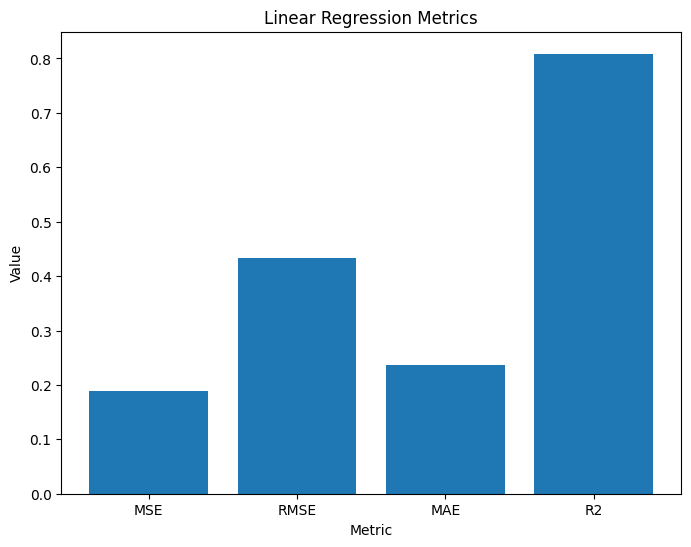

In [39]:
import matplotlib.pyplot as plt

metrics = ['MSE', 'RMSE', 'MAE','R2']
values = [GBmse, rmse, mae,r2]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Linear Regression Metrics')
plt.show()

In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



# Create a dictionary with all predictions
df = {'Actual': y_test, 'Predicted (LR)': LR_y_predict, 'Predicted (RF)': RF_y_pred, 'Predicted (GB)': GB_y_pred}

# Print the tabulated results
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='psql'))

+--------------+------------------+------------------+------------------+
|       Actual |   Predicted (LR) |   Predicted (RF) |   Predicted (GB) |
|--------------+------------------+------------------+------------------|
| -0.779867    |     -0.716425    |     -0.801557    |     -0.700085    |
| -0.811921    |     -0.679751    |     -0.743753    |     -0.66766     |
| -0.128101    |     -0.188209    |     -0.282815    |     -0.25028     |
| -0.726444    |     -0.592762    |     -0.474285    |     -0.586549    |
| -0.640966    |     -0.60885     |     -0.712019    |     -0.613746    |
| -0.299056    |     -0.231644    |     -0.206313    |     -0.196258    |
| -0.245633    |     -0.0543813   |     -0.213579    |     -0.124787    |
| -0.256317    |     -0.308852    |     -0.214861    |     -0.265887    |
| -0.598227    |     -0.291205    |     -0.340726    |     -0.34168     |
| -0.555489    |     -0.455517    |     -0.438812    |     -0.510645    |
| -0.51275     |     -0.266479    |   

Actual vs Predicted

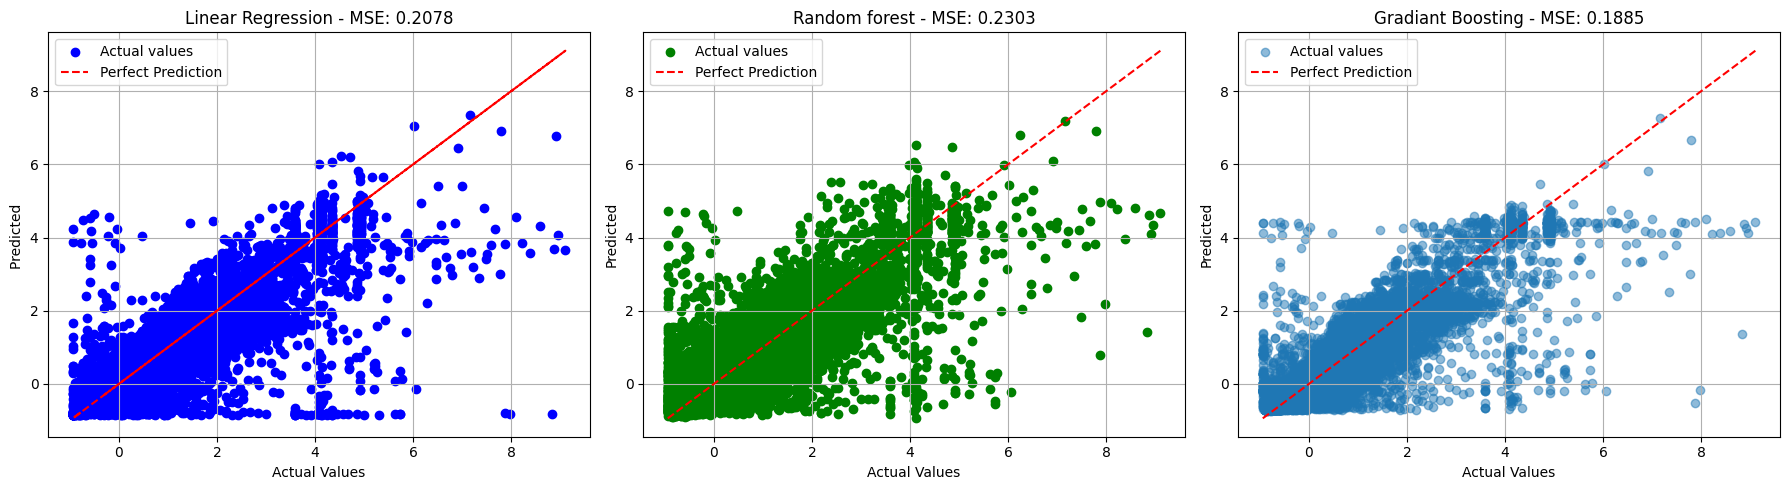

In [41]:
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs. Predicted scatter plot
ax1.scatter(y_test, LR_y_predict, color='blue', label='Actual values')
ax1.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted ')
ax1.set_title(f'Linear Regression - MSE: {LRmse:.4f}')
ax1.legend()
ax1.grid(True)

# Residuals plot
ax2.scatter(y_test, RF_y_pred, color='green', label='Actual values')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Random forest - MSE: {RFmse:.4f}')
ax2.legend()
ax2.grid(True)

# Histogram of residuals
ax3.scatter(y_test, GB_y_pred, alpha=0.5, label='Actual values')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted')
ax3.set_title(f'Gradiant Boosting - MSE: {GBmse:.4f}')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

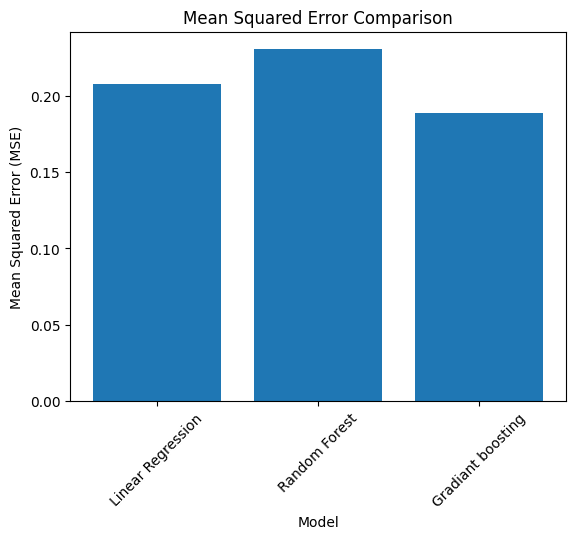

In [42]:
import matplotlib.pyplot as plt



# Create data for the bar chart
models = ['Linear Regression', 'Random Forest','Gradiant boosting']
mse_values = [LRmse, RFmse,GBmse]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
ax.bar(models, mse_values)

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Mean Squared Error Comparison')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the chart
plt.show()

CrossValidation


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Assuming you have your feature matrix X and target variable y
y_train=y_train.ravel()
# Linear Regression
lr = LinearRegression()
lr_scores = cross_val_score(lr, x_train, y_train, cv=5)
lr_mean_accuracy = lr_scores.mean()
print("Linear reg Cross-Validation Accuracy:", lr_mean_accuracy)

rf = RandomForestRegressor()
rf_score = cross_val_score(rf, x_train, y_train, cv=5)
rf_mean_accuracy = rf_score.mean()
print("Random Forest Cross-Validation Accuracy:", rf_mean_accuracy)

gb = GradientBoostingRegressor()
gb_score = cross_val_score(rf, x_train, y_train, cv=5)
gb_mean_accuracy = gb_score.mean()
print("Gradiant Boosting Cross-Validation Accuracy:", gb_mean_accuracy)


Linear reg Cross-Validation Accuracy: 0.7880728728792652


KeyboardInterrupt: 